### Imports and Set Up

In [1]:
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import time
import modelMLP 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
sc.settings.verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

### Prepping Data

In [2]:
#obtain data from file
adata =  sc.read_h5ad("data/Norman_2019.h5ad")  # replace with your path

In [7]:
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

In [5]:
#export data from sc.read
ddata = adata.X.toarray()
labels = adata.obs['perturbation_name'].to_numpy()
parsed_labels = [p.split('+') if p != 'control' else [] for p in labels]

In [6]:
#multilabel encode the data 
mlb = MultiLabelBinarizer()
labels_int = mlb.fit_transform(parsed_labels)

In [7]:
#split data
X_train, X_test, y_train, y_test = train_test_split(
    ddata, 
    labels_int, 
    test_size=0.2, 
    random_state=67, #SIX SEVEENNNNNNNNNN
    #stratify=labels_int
)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### MLP Model

In [27]:
input_size = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026
num_epochs = 25

model = modelMLP.MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)

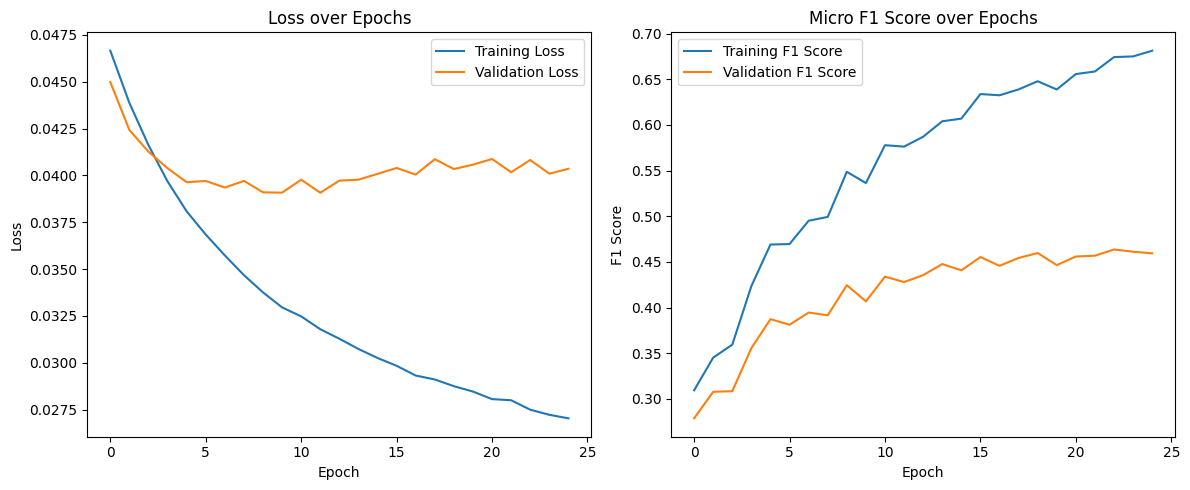

Epoch [25/25], Loss: 0.0383

Training Complete. Final Validation F1 Score: 0.4595


In [9]:
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(fig)


for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_test_loss = 0.0
    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.numpy())
            all_test_labels.append(labels.numpy())
        
        # Evaluate on training set (to compare train vs test performance)
        for inputs, labels in train_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.numpy())
            all_train_labels.append(labels.numpy())
        
    test_losses.append(current_test_loss / len(test_loader))
    
    # Calculate F1 score for this epoch
    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    test_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    

    # Clear the previous plot
    ax1.clear()
    ax2.clear()
    
    # Plot Loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot F1 Score (Accuracy)
    ax2.plot(train_f1_scores, label='Training F1 Score')
    ax2.plot(test_f1_scores, label='Validation F1 Score')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    
    fig.tight_layout()
    # Redraw the plot in the same cell
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1) # Small pause to allow plot to render

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Close the figure after the loop is done
plt.close(fig)

print(f"\nTraining Complete. Final Validation F1 Score: {test_f1_scores[-1]:.4f}")



### ATTN Model

In [30]:
from IPython.display import display, clear_output
from modelATTN import AttentiveMLP

input_dim = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026

learning_rate = 0.00026
weight_decay = 1.889e-6
attention_dim = 32  # A reasonable starting size for the attention bottleneck
hidden_dims = [100,219] # A list containing the size of each hidden layer. From your Optuna result: 1 layer of size 219.
dropout_p = 0.3
num_epochs = 50

model = AttentiveMLP(
    input_dim=input_dim,
    num_classes=num_classes,
    attention_dim=attention_dim,
    hidden_dims=hidden_dims,
    dropout_p=dropout_p
)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)

### MHA Model

##### More embedding

In [9]:
import pyensembl
from tqdm import tqdm

In [10]:
data = pyensembl.EnsemblRelease(109)
data.download()
data.index()

gene_names = adata.var['index']

gene_data = []
for gene_name in tqdm(gene_names):
    try:
        gene = data.gene_by_id(gene_name)
        gene_data.append({
            'gene_name': gene_name,
            'contig': gene.contig,
            'start': gene.start,
            'end': gene.end
        })
    except ValueError:
        # This happens if the gene name is not found in the database
        gene_data.append({
            'gene_name': gene_name,
            'contig': None,
            'start': None,
            'end': None
        })

gene_info_df = pd.DataFrame(gene_data)



INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/steveyin/Library/Caches/pyensembl/GRCh38/ensembl109/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
100%|██████████| 19018/19018 [00:00<00:00, 96520.07it/s]


In [11]:
chromosome_lengths = {
    # Autosomes
    '1': 248956422,
    '2': 242193529,
    '3': 198295559,
    '4': 190214555,
    '5': 181538259,
    '6': 170805979,
    '7': 159345973,
    '8': 145138636,
    '9': 138394717,
    '10': 133797422,
    '11': 135086622,
    '12': 133275309,
    '13': 114364328,
    '14': 107043718,
    '15': 101991189,
    '16': 90338345,
    '17': 83257441,
    '18': 80373285,
    '19': 58617616,
    '20': 64444167,
    '21': 46709983,
    '22': 50818468,
    # Sex Chromosomes
    'X': 156040895,
    'Y': 57227415
}

chr_names = [str(i) for i in range(1, 23)] + ['X', 'Y']
chromosome_map = {name: i for i, name in enumerate(chr_names)}

In [15]:
def positional_encoding(row):
    """Takes a row from our gene_info_df and creates the encoding vector."""
    encoding = np.zeros(24)
    
    contig = row['contig']
    start = row['start']
    
    if pd.notna(contig) and contig in chromosome_map:
        chr_index = chromosome_map[contig]
        chr_length = chromosome_lengths[contig]
        
        # Calculate normalized position (the magnitude)
        normalized_position = start / chr_length
        encoding[chr_index] = normalized_position
        
    return encoding

positional_encodings = np.array(gene_info_df.apply(positional_encoding, axis=1).tolist())
positional_encodings

array([[0.00011871, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00035868, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00074397, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

##### Prepping Model

In [ ]:
from modelTRAN import TransMLP

input_size = X_train.shape[1] # Number of genes
num_classes = labels_int[0].size
learning_rate = 0.00026
num_epochs = 25

model = modelMLP.MLP(input_size=input_size, num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss() # Best for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 2e-6)





### Running Model

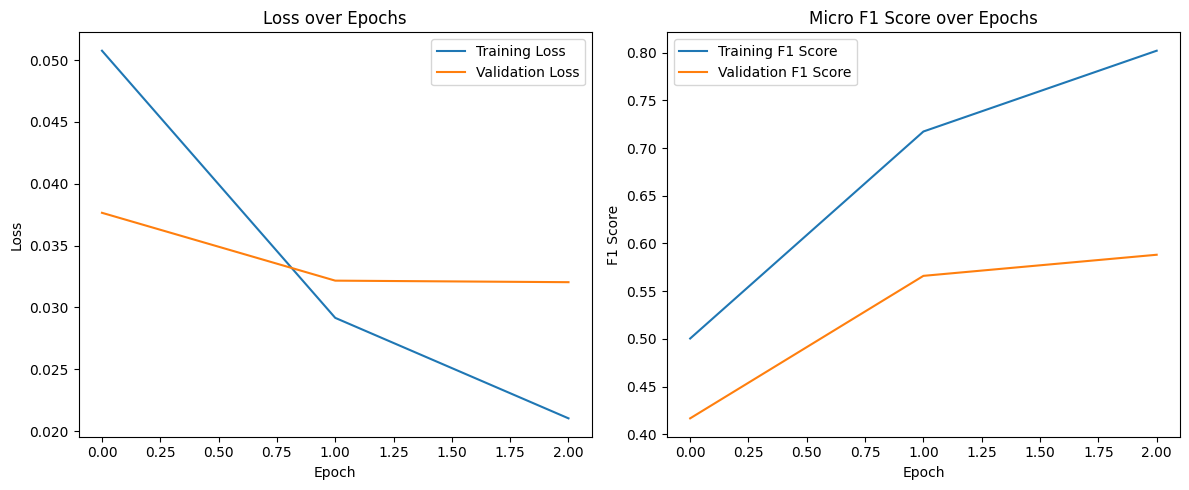

Epoch [3/50], Train Loss: 0.0210, Val Loss: 0.0320, Val F1: 0.5882


KeyboardInterrupt: 

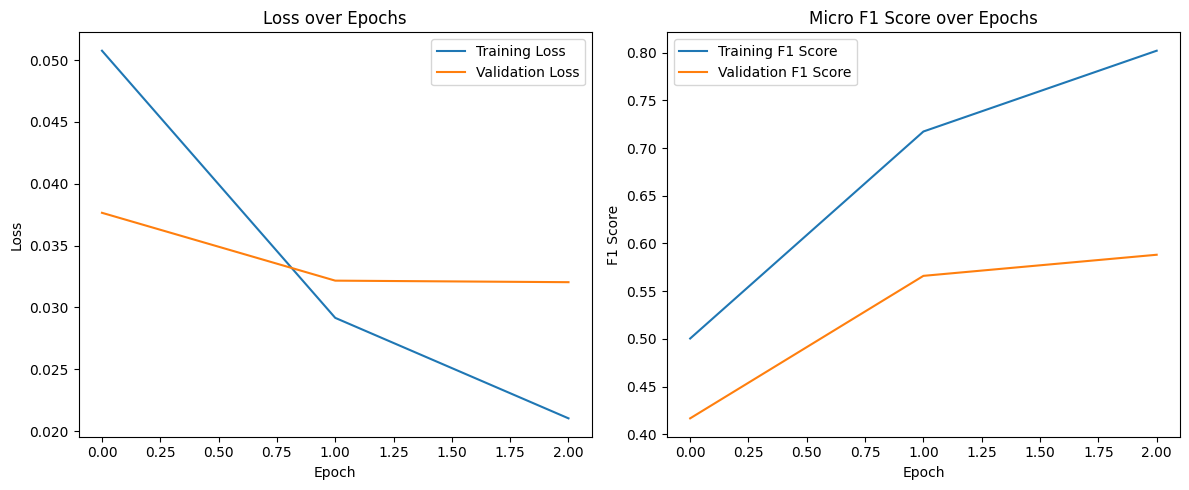

In [31]:



# --- 2. Set Hyperparameters & Initialize Model ---

# We'll use the best parameters from your previous Optuna search as a starting point
# and add a parameter for the attention layer's complexity.

# Instantiate the new model with these parameters

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# --- 3. Run the Training and Plotting Loop ---
# (This is your exact code from before)

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
display(fig)

for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_test_loss = 0.0
    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            current_test_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_test_preds.append(preds.numpy())
            all_test_labels.append(labels.numpy())
        
        for inputs, labels in train_loader:
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.append(preds.numpy())
            all_train_labels.append(labels.numpy())
        
    test_losses.append(current_test_loss / len(test_loader))
    
    train_f1 = f1_score(np.vstack(all_train_labels), np.vstack(all_train_preds), average='micro')
    test_f1 = f1_score(np.vstack(all_test_labels), np.vstack(all_test_preds), average='micro')
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    
    ax1.clear()
    ax2.clear()
    
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_f1_scores, label='Training F1 Score')
    ax2.plot(test_f1_scores, label='Validation F1 Score')
    ax2.set_title('Micro F1 Score over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    
    fig.tight_layout()
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {test_losses[-1]:.4f}, Val F1: {test_f1_scores[-1]:.4f}')

plt.close(fig)
print(f"\nTraining Complete. Final Validation F1 Score: {test_f1_scores[-1]:.4f}")